<h1>Load yours data</h1>

In [1]:
# -- Import --
import pandas as pd
import ta
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from math import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sys
import ccxt
sys.path.append( '../../utilities' )
from data_engine import DataEngine

# -- You can change the crypto pair ,the start date and the time interval below --
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='../database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

print("Data loaded 100%")

# -- Uncomment the line below if you want to check your price dataset --
# df

Successfully load 40803 candles for ETHUSDT
Data loaded 100%


<h1>Define your indicators</h1>

In [2]:
# -- Indicator variable --
trixLength = 9
trixSignal = 19
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)


print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,NaN,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,NaN,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-26 15:00:00,2783.21,2809.51,2779.78,2785.08,19188.69340,2760.835893,0.069697,0.234679,-0.164982,0.440062
2022-02-26 16:00:00,2785.15,2799.50,2780.40,2790.02,8123.47320,2762.697547,0.067431,0.225560,-0.158129,0.518205
2022-02-26 17:00:00,2790.01,2796.10,2782.61,2790.91,6871.36720,2764.559939,0.067412,0.215868,-0.148456,0.531632


<h1>Overbought optimizer</h1>

Loading... 52 / 52


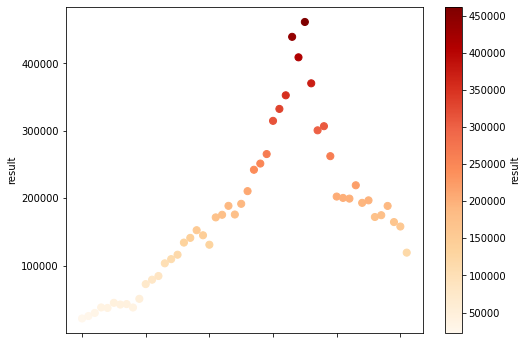

    param1         result
0     50.0   22110.239009
1     51.0   25738.146724
2     52.0   30332.035528
4     54.0   37734.274659
8     58.0   38374.086621
3     53.0   38445.485618
6     56.0   42727.971893
7     57.0   43436.475573
5     55.0   45297.614313
9     59.0   51219.986909
10    60.0   73057.007502
11    61.0   79577.204746
12    62.0   85040.522368
13    63.0  103843.763208
14    64.0  110040.750614
15    65.0  116587.467282
51   101.0  119676.457723
20    70.0  131384.797893
16    66.0  134552.703211
17    67.0  141536.301731
19    69.0  145397.935288
18    68.0  152900.057574
50   100.0  158381.941666
49    99.0  164989.895218
21    71.0  171900.774852
46    96.0  172471.678058
47    97.0  175161.420382
22    72.0  175750.059236
24    74.0  176163.484604
48    98.0  188875.277044
23    73.0  188990.238503
25    75.0  192005.055898
44    94.0  193432.478185
45    95.0  197147.841582
42    92.0  199699.458238
41    91.0  200744.226233
40    90.0  202755.378846
26    76.0  

In [3]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2017-01-01':]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0:
        return True
  else:
        return False

loopI = [50, 102, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

count = 0
maxCount = enumI
for i in range(loopI[0], loopI[1], loopI[2]):
  count += 1
  clear_output(wait=True)
  print("Loading...",count,'/',maxCount)
  # -- You can change variables below --
  usdt = 1000
  coin = 0

  stochTop = i / 100

  previousRow = dfTest.iloc[0]

  for index, row in dfTest.iterrows():
    #BUY
    if buyCondition(row, stochTop) and usdt > 0:
      coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
      usdt = 0

    #SELL
    elif sellCondition(row) and coin > 0:
      usdt = coin * row['close'] - (0.0007 * coin * row['close'])
      coin = 0

  myrow = {'param1': i,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
  dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y=1,c='result',s=50,colormap='OrRd',figsize=(8,6))

plt.show()

print(dt.sort_values(by=['result']))

<h2>Trix Parameters Optimizer</h2>

Loading... 260 / 260


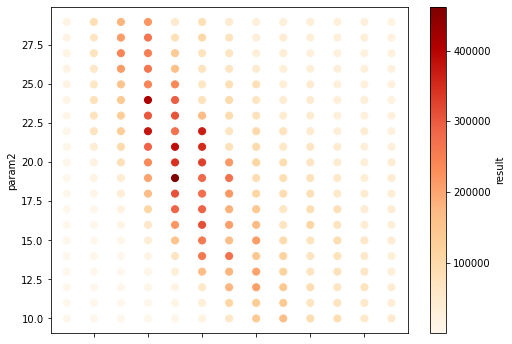

     param1  param2         result
2       5.0    12.0      40.418483
20      6.0    10.0      43.469847
1       5.0    11.0      44.260579
0       5.0    10.0      46.507969
3       5.0    13.0      53.547182
..      ...     ...            ...
112    10.0    22.0  368142.908958
72      8.0    22.0  377860.960015
91      9.0    21.0  385810.287836
74      8.0    24.0  408107.390820
89      9.0    19.0  461466.839942

[260 rows x 3 columns]


In [3]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df[:]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0:
        return True
  else:
        return False

loopI = [5, 18, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

loopJ = [10, 30, 1]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

count = 0
maxCount = enumI * enumJ
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    count += 1
    clear_output(wait=True)
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    trixLength = i
    trixSignal = j
    # -- Indicators, you can edit every value --
    dfTest['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=dfTest['close'], window=trixLength), window=trixLength), window=trixLength)
    dfTest['TRIX_PCT'] = dfTest["TRIX"].pct_change()*100
    dfTest['TRIX_SIGNAL'] = ta.trend.sma_indicator(dfTest['TRIX_PCT'], trixSignal)
    dfTest['TRIX_HISTO'] = dfTest['TRIX_PCT'] - dfTest['TRIX_SIGNAL']

    stochTop = 0.85

    previousRow = dfTest.iloc[0]

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row, stochTop) and usdt > 0:
        coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
        usdt = 0

      #SELL
      elif sellCondition(row) and coin > 0:
        usdt = coin * row['close'] - (0.0007 * coin * row['close'])
        coin = 0

    myrow = {'param1': i, 'param2': j,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='OrRd',figsize=(8,6))
plt.show()

print(dt.sort_values(by=['result']))

<h1>Stock RSI Optimizer</h1>

Loading... 29 / 29


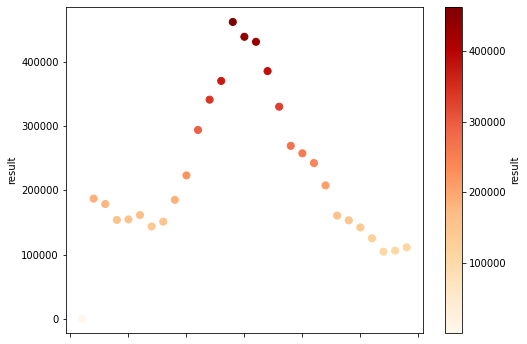

    param1         result
0      1.0    1000.000000
26    27.0  104712.409446
27    28.0  106411.996818
28    29.0  111480.318328
25    26.0  125462.932739
24    25.0  142394.524917
6      7.0  143862.803202
7      8.0  151315.294302
23    24.0  153395.862621
3      4.0  154109.400279
4      5.0  154817.553848
22    23.0  160752.148935
5      6.0  161620.358627
2      3.0  178749.258227
8      9.0  185244.177728
1      2.0  187127.331764
21    22.0  207692.102231
9     10.0  223213.056821
20    21.0  242324.214316
19    20.0  257502.567215
18    19.0  269128.215857
10    11.0  293727.085849
17    18.0  329882.790750
11    12.0  340830.947814
12    13.0  369934.638957
16    17.0  385215.792076
15    16.0  430655.345566
14    15.0  438462.349092
13    14.0  461466.839942


In [5]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df[:]

# -- Condition to BUY market --
def buyCondition(row, stochOverBought):
  if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0:
        return True
  else:
        return False

loopI = [1, 30, 1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

count = 0
maxCount = enumI
for i in range(loopI[0], loopI[1], loopI[2]):
    count += 1
    clear_output(wait=True)
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=i, smooth1=3, smooth2=3)

    stochTop = 0.85

    previousRow = dfTest.iloc[0]

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row, stochTop) and usdt > 0:
        coin = (usdt/row['close']) - 0.0007 * (usdt/row['close'])
        usdt = 0

      #SELL
      elif sellCondition(row) and coin > 0:
        usdt = coin * row['close'] - (0.0007 * coin * row['close'])
        coin = 0

    myrow = {'param1': i,'result': coin * dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y=1,c='result',s=50,colormap='OrRd',figsize=(8,6))

plt.show()

print(dt.sort_values(by=['result']))